# XY 2022
## Example notebook + questions

### F1


In [ ]:
# prerequisites: 
previous_xy_mapping = os.getcwd()+'/Files/Guider2UV_F4_nogamma.new.pkl'
mask_det_map_file = '../Calibration/Mappings/mapping-mask-det-w-1806012-F4.pkl'
target_filename = '../Calibration/Targets/2022/targets_F4.txt'

In [2]:
%matplotlib inline
import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table
import matplotlib.patches as patches

sys.path.insert(1, '../../Calibration')
sys.path.append( '../../FireBallPipe')
from guider2UV.guider2UV import Guider2UV, diff_skycoord
from Calibration.mapping import Mapping

In [3]:
#mask_plate_scale = 42.26134 #mm/deg
#detector platescale
#yscale = 1.106 # arcsec/pix spatial (y det -> y mask)
#xscale = 1.271 # arcsec/pix spectral (x det -> - x mask)

#guider center => put source on guider center
gc = np.array([640, 540])

## calibrated frame encoder gains:

EL : 0.092 x ? = ? arcsec/inc

CE : 0.01 x ? = ? arcsec/inc

In [45]:
# encoder gains:
CEg = 1.02928
Elg = 1.00379


## initialization from last xy calib
This is to know where we begin. 

We can directly do this for F1 and F4, by using 2018 calibration.

For F2, F3 and QSO field we need to have a first mapping... how?

In [48]:
# Open last XY mapping from 2018
G2UV = Guider2UV(filename=os.getcwd()+'/Files/Guider2UV_F4_nogamma.new.pkl')
gc_coord = G2UV.GuiderP.pix2local([gc])

# Open new slits positions 
target_filename = '../Calibration/Targets/2022/targets_F4.txt'
F4 = Table.read(target_filename, format='ascii')


FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39242605, 36.41307253)>): (lon, lat) in deg
    (0.18585616, 0.01856568)>
FOV center pixel position in guider [array(1377.264363), array(605.11696717)]


## Diffuse UV image

load new mapping

In [58]:
# We actually do not need here the diffuse image. Don't know why Didier was oppening it
diffuse_tab = Table.read(filename=os.getcwd()+'/Files/StackedImage_44-63-NoDark_table.csv', format='csv')
# Open new mask to detector mapping that we made after last shimming iteration.

mask_det_map_file = '../Calibration/Mappings/mapping-mask-det-w-1806012-F4.pkl'
# mask_det_map_file = '../Calibration/Mappings/2022/mapping-mask-det-w-2022-5-F4.pkl'
mask_det_map = Mapping(mask_det_map_file)
dxm_dyd = -0.013
dym_dxd = -0.015
m = np.array([[0., dxm_dyd],[dym_dxd ,0.]])

record shift from mapping



In [66]:
# I guess here we write in both direction the x-y offset we have from
#  diffuse illumination used to create the mapping and the one we take
# just before the XY calib
 
diffuse_offset = [ 16.0+1, 1.8+1] 
# definition of the mapping mask to detector and detector to mask
direct_map = lambda w, x, y: mask_det_map.map(w, x, y) + diffuse_offset
inv_map = lambda w, x, y: mask_det_map.inv_map(w, x - diffuse_offset[0], y - diffuse_offset[1])

## Scan sequence
Guider center

then do 8 slits 

then do 4 stars 

then go to guider center

gc - 31 - 40 - 44 - 33 - 23 - 6  - 8 - 13 - gc - s18 - s29 - s34 - s14 - gc

### Go from guider to 1st slit: #31

In [67]:
# x,y position from slit 31
slit_pos1 =   np.array([F4[F4['Internal-count']=='31']['x_mm'][0], F4[F4['Internal-count']=='31']['y_mm'][0]])

print("slit position in mm on mask:", slit_pos1)
slit_coord1 = G2UV.SienceMask2guider(slit_pos1, angle=True)
print("slit coord in guider local frame:", slit_coord1.to_string(u'dms'))

#I guess frame move from guider center to slit 31. How do you take into account the guider center?
# we do not care because gc_coord is almost 0,0?
theta_EL =  slit_coord1.lon.deg/2./Elg
theta_CE = -slit_coord1.lat.deg/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

slit position in mm on mask: [ 4.853195 -3.812219]
slit coord in guider local frame: ['0d05m48.03789274s -0d05m49.86729775s']
EL: [173.36190475] arcsec 
CE: [169.95729916] arcsec


### Go from guider to 1st slit: #31

remove offset from model to prediction

In [68]:

slit_coord1_det = direct_map(0.2139, slit_pos1[0], slit_pos1[1])
# slit_coord1_det = direct_map(mask_det_map.w[1], slit_pos1[0], slit_pos1[1])
print("mapped slit position on detector: ", slit_coord1_det)

mapped slit position on detector:  [1434.8650639   585.43183891]


In [69]:
# compute observed position on det
slit_coord1_obs_det = np.array([1776.2, 623.6]) # observed
slit_coord1_obs_wave = 0.20619
#compute observed position in mask frame
slit_pos1_obs = inv_map(slit_coord1_obs_wave, slit_coord1_obs_det[0], slit_coord1_obs_det[1])
# I don't understand this formula. How can you add to a mm position a difference in 
# detector coordinates?
slit_pos1_obs2 = slit_pos1 + m.dot(slit_coord1_obs_det - slit_coord1_det)
print("observed slit position in mm on mask:", slit_pos1_obs)
print("observed slit position (linear mapping) in mm on mask:", slit_pos1_obs2)


observed slit position in mm on mask: [ 4.36749312 -3.50296168]
observed slit position (linear mapping) in mm on mask: [ 4.35700891 -8.93224304]


In [70]:

# Here the only difference in the angle... Don't understand that.
slit_coord1_obs = G2UV.SienceMask2guider(slit_pos1_obs, angle=True)
print("observed slit coord in guider local frame:", slit_coord1_obs.to_string(u'dms'))
slit_coord1_obs_pix = G2UV.SienceMask2guider(slit_pos1_obs, angle=False)
print("observed slit coord in guider pixel frame:", slit_coord1_obs_pix)


observed slit coord in guider local frame: ['0d06m14.03817827s -0d05m08.18386659s']
observed slit coord in guider pixel frame: [array([1060.29403101]), array([188.59037517])]


In [71]:
offset =  diff_skycoord(slit_coord1_obs, slit_coord1) 
print("offset from guider in arcsec (guider frame): \n",offset*3600)


offset from guider in arcsec (guider frame): 
 [[-26.00028552]
 [-41.68343116]]


## create new mapping

In [72]:
# new mapping has the same form than previous one
G2UVnew  = G2UV.copy()
# add the previously computed offset to the previous mapping
newFOVcenter = coordinates.SkyCoord(G2UV.FOV_center_guider_coord.lon + offset[0]*u.deg, 
                              G2UV.FOV_center_guider_coord.lat + offset[1]*u.deg,
                              frame = G2UV.GuiderP.localframe)
# Apply this new center to the new mapping
G2UVnew.FOV_center_guider_coord = newFOVcenter


In [74]:
#Use the new mapping with offset to predict new position of slit
slit_coord1_cor = G2UVnew.SienceMask2guider(slit_pos1, angle=True)
print("slit coord in guider local frame, corrected from offset:", slit_coord1_cor.to_string(u'dms'))


slit coord in guider local frame, corrected from offset: ['0d05m22.03760722s -0d06m31.55072891s']


### go back to guider center (absolute)

go to 1st slit, offset removed:

In [76]:
# to go to the previously computed slit you need to do the following frame move:
# we divide by 2 as we are in autocoll
theta_EL =  slit_coord1.lon.deg/2./Elg
theta_CE = -slit_coord1.lat.deg/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))
# Do we need now to verify that we are at thr right position? If we are not, it's that
# the offset was not well taken into account?

EL: [173.36190475] arcsec 
CE: [169.95729916] arcsec


### Loop on slits
Do we need to add slits += slits[::-1]?

In [143]:
slits = ['31', '40', '44', '33', '23', '6', '8', '13'] 
# slits += slits[::-1]
# print(slits)
mask = F4.to_pandas()['Internal-count'].isin(slits)
selected_slits = F4[mask.values]['Internal-count',"x_mm","y_mm","RA","DEC"]
print(selected_slits)

Internal-count    x_mm      y_mm       RA      DEC   
-------------- --------- --------- --------- --------
             6  -8.51572  4.436704 36.704784 0.756674
             8 -7.570966    1.9379 36.727066 0.698124
            13 -5.303522 -0.138687 36.780373 0.647485
            23  1.149408  -0.37309 36.931808 0.643882
            31  4.853195 -3.812219 37.018761  0.56313
            33  5.386155   4.42581 37.031296 0.756175
            40  8.811543 -3.028793 37.111828 0.581537
            44 10.563193  2.136243 37.153091 0.702315


In [172]:
slit_pos = np.zeros((len(slits),2))
slit_coord = [] # filed with SienceMask2guider(slit_pos[i], angle=True)
slit_coord_pix = np.zeros((len(slits),2)) # filed with G2UVnew.SienceMask2guider(slit_pos[i], angle=False)
theta_EL = np.zeros(len(slits)) # moves that will need to be done
theta_CE = np.zeros(len(slits))

for i, s in enumerate(slits):
    
    slit_pos[i] = np.array([F4[F4['Internal-count']==s]['x_mm'][0], F4[F4['Internal-count']==s]['y_mm'][0]])
    # print("Slit %i position in mm on mask:"%(i), slit_pos[i])
    slit_coord.append(G2UVnew.SienceMask2guider(slit_pos[i], angle=True))
    # print("Slit %i coord in guider local frame:"%(i), slit_coord[-1].to_string(u'dms'))
    slit_coord_pix[i] = np.array(G2UVnew.SienceMask2guider(slit_pos[i], angle=False)).T
    # print("Slit %i coord in guider pixel frame:"%(i), slit_coord_pix[i])

    #frame movevement 
    theta_EL[i] =  slit_coord[-1].lon.deg/2./Elg
    theta_CE[i] = -slit_coord[-1].lat.deg/2./CEg
    # print("EL: {:.1f} arcsec \nCE: {:.1f} arcsec".format(theta_EL[i]*3600, theta_CE[i]*3600))
    # print("-------------")

# compute relative moves
moves_EL = theta_EL[1:] - theta_EL[:-1]
moves_CE = theta_CE[1:] - theta_CE[:-1]
selected_slits["xmm_pred"] = slit_pos[:,0]
selected_slits["ymm_pred"] = slit_pos[:,1]
# selected_slits["x_glf_pred"] = slit_coord[:,0]
selected_slits["xy_glf_pred"] = slit_coord
selected_slits["x_gpix_pred"] = slit_coord_pix[:,0]
selected_slits["y_gpix_pred"] = slit_coord_pix[:,1]
selected_slits["theta_EL"] = theta_EL
selected_slits["theta_CE"] = theta_CE

selected_slits['Internal-count',"xmm_pred","ymm_pred","xy_glf_pred","x_gpix_pred","y_gpix_pred","theta_EL","theta_CE"]

Internal-count,xmm_pred,ymm_pred,xy_glf_pred,x_gpix_pred,y_gpix_pred,theta_EL,theta_CE
,,,"deg,deg",,,,
str7,float64,float64,SkyCoord,float64,float64,float64,float64
6,4.853195,-3.812219,"0.08945489089506517,-0.10876409136372321",1005.2794286336583,93.27246029125091,0.04455856847301984,0.05283503583268072
8,8.811543,-3.028793,"0.10883184611760682,-0.2024608944480025",1095.871349529831,-295.6712247612692,0.054210465394956525,0.0983507376263031
13,10.563193,2.136243,"0.23162135760719532,-0.2429245397592568",1578.8353423022463,-460.71257555716613,0.11537341356618183,0.11800702421073798
23,5.386155,4.42581,"0.28463278664258745,-0.11957137011046146",1759.123449283211,42.34695715031819,0.14177905071906846,0.05808495749964123
31,1.149408,-0.37309,"0.17006082610219198,-0.020294194109180916",1316.0786011641105,451.0044460809549,0.0847093645594158,0.009858441876448059
33,-8.51572,4.436704,"0.2818680377051379,0.20975537231778413",1761.5413264744411,1333.3726013720427,0.14040189566798728,-0.10189422330064907
40,-7.570966,1.9379,"0.22284788559496477,0.18672921205859702",1534.5263466634883,1257.8027134927486,0.11100324051592703,-0.09070865656507317
44,-5.303522,-0.138687,"0.17417219287899036,0.13250295031859852",1340.0062693305288,1056.1203952256876,0.08675728632432599,-0.06436681482133069


In [163]:
# remove middle
# We should not remove middle if we do not add slit[::-1]
# why 6 moves and not 7?
idx = np.arange(len(slits)//2)
idx = np.concatenate((idx[:-1], idx[:-1]+len(idx)))
for i in idx:
    print("move %i :  EL %0.1f arcsec - CE %0.1f arcsec"%(i,moves_EL[i]*3600, moves_CE[i]*3600))


move 0 :  EL 34.7 arcsec - CE 163.9 arcsec
move 1 :  EL 220.2 arcsec - CE 70.8 arcsec
move 2 :  EL 95.1 arcsec - CE -215.7 arcsec
move 4 :  EL 200.5 arcsec - CE -402.3 arcsec
move 5 :  EL -105.8 arcsec - CE 40.3 arcsec
move 6 :  EL -87.3 arcsec - CE 94.8 arcsec


Write down the barycentered observed slits position :

In [171]:
# slit_coord_obs_det = np.zeros((8,2)) + np.array([1800, 421])
slit_coord_obs_det = np.array([[ 1803 ,  421.2 ],
        [ 1469.6 ,  288.7 ],
        [ 1304.2 , 1347.9 ],
        [ 1619.6 ,  1625.4 ],
        [ 1620 ,  1626.6 ],

        [ 1304.3 ,  1355.6 ],
        [ 1469.5 ,  288.7 ],
        [ 1802.9 ,  412.5 ]])
selected_slits["x_dpix_obs"] = slit_coord_obs_det[:,0]
selected_slits["y_dpix_obs"] = slit_coord_obs_det[:,1]
print("Observed slits positions are:")
selected_slits['Internal-count',"x_dpix_obs","y_dpix_obs"]

Observed slits positions are:


Internal-count,x_dpix_obs,y_dpix_obs
str7,float64,float64
6,1803.0,421.2
8,1469.6,288.7
13,1304.2,1347.9
23,1619.6,1625.4
31,1620.0,1626.6
33,1304.3,1355.6
40,1469.5,288.7
44,1802.9,412.5


In [175]:
slit_pos_offset = mask_det_map.map(0.2139, slit_pos[:,0], slit_pos[:, 1]).T + diffuse_offset
selected_slits["x_dpix_obs_off"] = slit_pos_offset[:,0]
selected_slits["y_dpix_obs_off"] = slit_pos_offset[:,1]
print("Observed slits positions with offset are: ")
selected_slits['Internal-count',"x_dpix_obs","y_dpix_obs","x_dpix_obs_off","y_dpix_obs_off"]

Observed slits positions with offset are: 


Internal-count,x_dpix_obs,y_dpix_obs,x_dpix_obs_off,y_dpix_obs_off
str7,float64,float64,float64,float64
6,1803.0,421.2,1434.8650639047241,585.4318389144532
8,1469.6,288.7,1374.0646684855358,282.6683321302842
13,1304.2,1347.9,1023.6213263757355,154.47212256836147
23,1619.6,1625.4,880.9704115754898,557.8605379516365
31,1620.0,1626.6,1212.5918542880215,874.2873592098728
33,1304.3,1355.6,895.6365605263172,1624.9946945186036
40,1469.5,288.7,1064.253421103943,1549.728941752119
44,1802.9,412.5,1203.386652592604,1371.473072956389


map on mask :

In [97]:
# compute the position in the mask frame of the slit probed at the central wavelength or barycentered over the 3 waves
slit_coord_obs_wave = 0.20619    

#slit_pos_obs = mask_det_map.inv_map(slit_coord_obs_wave, slit_coord_obs_det[:,0], slit_coord_obs_det[:,1]).T
slit_pos_obs = inv_map(slit_coord_obs_wave, slit_coord_obs_det[:,0], slit_coord_obs_det[:,1]).T


In [181]:
slit_coord_obs = []
slit_coord_obs_pix = np.zeros((len(slits),2))

# for i, s in enumerate(slit_pos_obs):
for i, s in enumerate(slits):# change vincent
    print("observed slit %i position in mm on mask:"%(i), slit_pos_obs[i])
    slit_coord_obs.append(G2UVnew.SienceMask2guider(slit_pos_obs[i], angle=True))
    print("observed slit %i coord in guider local frame:"%(i), slit_coord_obs[-1].to_string(u'dms'))
    slit_coord_obs_pix[i] = np.array(G2UVnew.SienceMask2guider(slit_pos_obs[i], angle=False)).T
    print("observed slit coord in guider pixel frame:", slit_coord_obs_pix[i])
    print("-------------")

selected_slits["xmm_obs"] = slit_pos_obs[:,0]
selected_slits["ymm_obs"] = slit_pos_obs[:,1]

selected_slits["xy_g_obs"] = slit_coord_obs#[:,0]
# selected_slits["ymm_obs"] = slit_coord_obs[:,1]

selected_slits["x_gpix_obs"] = slit_coord_obs_pix[:,0]
selected_slits["y_gpix_obs"] = slit_coord_obs_pix[:,1]

selected_slits['Internal-count',"xmm_obs","ymm_obs","xy_g_obs","x_gpix_obs","y_gpix_obs"]

observed slit 0 position in mm on mask: [ 6.9958932  -3.98569701]
observed slit 0 coord in guider local frame: ['0d05m08.83154164s -0d09m34.55986535s']
observed slit coord in guider pixel frame: [ 997.33248824 -117.69146038]
-------------
observed slit 1 position in mm on mask: [8.8177731  0.93034368]
observed slit 1 coord in guider local frame: ['0d12m09.4864078s -0d12m06.12768296s']
observed slit coord in guider pixel frame: [1459.81502663 -290.03807805]
-------------
observed slit 2 position in mm on mask: [-4.89687232  3.70343821]
observed slit 2 coord in guider local frame: ['0d15m54.81768072s 0d07m25.49001266s']
observed slit coord in guider pixel frame: [1686.93209582 1006.77452425]
-------------
observed slit 3 position in mm on mask: [-8.61528237 -0.946206  ]
observed slit 3 coord in guider local frame: ['0d09m15.49131885s 0d12m39.11291293s']
observed slit coord in guider pixel frame: [1274.83650397 1363.72718512]
-------------
observed slit 4 position in mm on mask: [-8.63108

Internal-count,xmm_obs,ymm_obs,xy_g_obs,x_gpix_obs,y_gpix_obs
,,,"deg,deg",,
str7,float64,float64,SkyCoord,float64,float64
6,6.99589320064003,-3.9856970054895466,"0.08578653934502586,-0.15959996259729778",997.3324882373652,-117.69146037796624
8,8.817773100021933,0.9303436842348247,"0.2026351132768643,-0.20170213415491536",1459.8150266265584,-290.0380780532258
13,-4.896872318965984,3.7034382068660086,"0.26522713353358146,0.12374722573759155",1686.9320958229325,1006.7745242460092
23,-8.615282367081317,-0.9462059956722808,"0.15430314412404675,0.21086469803732893",1274.836503968749,1363.7271851216644
31,-8.631089146935846,-0.9520514061022937,"0.15416105193985155,0.21123871808560005",1274.3534242027388,1365.1964820494434
33,-4.997349461286163,3.703058206865721,"0.265197095583133,0.1261277905381657",1687.0735807687743,1015.9931353616919
40,8.817806641107307,0.9318262104896804,"0.2026702434919065,-0.20170260956133026",1459.9497306083902,-290.03998621559737
44,7.108715148078854,-3.9877391686023653,"0.08576101008363483,-0.16227674615659868",997.6518460255909,-128.85211617830362


## compute NEW MODEL: orientation, offset & magnification

In [185]:
slit_coord_F = np.zeros((len(slits),2))
slit_coord_obs_F = np.zeros((len(slits),2))

for i in range(len(slits)): #change vincent
# for i in range(len(slit_coord_obs)):
    
    c     = G2UVnew.guider_to_FieldLocal(slit_coord[i], angle=True)
    slit_coord_F[i] = np.array([ c.lon.deg, c.lat.deg]).T
    # only difference is slit_coord vs slit_coord_obs
    c_obs = G2UVnew.guider_to_FieldLocal(slit_coord_obs[i], angle=True)
    slit_coord_obs_F[i] = np.array([ c_obs.lon.deg, c_obs.lat.deg]).T

    
delta = slit_coord_obs_F - slit_coord_F
# print(delta*3600) # give the difference in arcseconds between the regular position of slits and the one observed
# slit_coord_obs_F
selected_slits["x_obs-orig"] = delta[:,0]*3600
selected_slits["y_obs-orig"] = delta[:,1]*3600
selected_slits['Internal-count',"xmm_obs","ymm_obs","x_obs-orig","y_obs-orig"]

Internal-count,xmm_obs,ymm_obs,x_obs-orig,y_obs-orig
str7,float64,float64,float64,float64
6,6.99589320064003,-3.9856970054895466,-14.924139478921461,-182.88515904267635
8,8.817773100021933,0.9303436842348247,337.7174052063412,-0.43868391353837355
13,-4.896872318965984,3.7034382068660086,133.3730111627254,1318.8825985945173
23,-8.615282367081317,-0.9462059956722808,-458.01913454019495,1193.9745294977654
31,-8.631089146935846,-0.9520514061022937,-49.4141877556558,834.0558404237801
33,-4.997349461286163,3.703058206865721,-62.84171018167638,-300.4958751155623
40,8.817806641107307,0.9318262104896804,-85.7671428687611,-1397.6726243977516
44,7.108715148078854,-3.9877391686023653,-328.2427764616159,-1058.2189198551632


In [187]:
# compute new model:
# add units of gamma
row_x = np.hstack((slit_coord_F*[1.,-1], np.ones((8,1)), np.zeros((8,1)) )) # xn -x = x dgamma - y theta + dx
row_y = np.hstack((slit_coord_F[:,::-1], np.zeros((8,1)), np.ones((8,1)) )) # yn - y = x theta - y dgamma 
mat = np.vstack((row_x, row_y))
matinv =  np.linalg.pinv(mat)
data = np.concatenate((delta[:,0], delta[:,1]))
sol = matinv.dot(data)
gama = 1 + sol[0]
theta_rad = sol[1]
deltax = sol[2]
deltay = sol[3]
theta = theta_rad*180/np.pi*60 #arcmin
print("gamma: {}\ntheta: {} arcmin\ndx: {} arcsec\ndy: {} arcsec".format(gama, theta, deltax*3600, deltay*3600))
covar = matinv.dot(matinv.T)
# accuracy, assuming 1 arcsec measurement error
print("variances: {}\n".format(np.sqrt(np.diag(covar))/3600*[1, 180/np.pi*60, 3600, 3600])) #
#residual
data_new = mat.dot(sol) 
print("residuals in arcsec:", (data_new - data)*3600)

gamma: -0.061174855001148165
theta: 849.2557585474365 arcmin
dx: -27.516059820613332 arcsec
dy: -69.91196286597793 arcsec
variances: [5.48046431e-04 1.88404485e+00 3.59260143e-01 3.59260143e-01]

residuals in arcsec: [ 434.44081521   94.62515345 -131.65232302  143.53992789   79.81810224
 -545.79254056 -276.58548238  201.60634717  471.69371996  664.33586432
 -387.13767276 -683.3908304  -807.90713532 -446.83254793  683.51157709
  505.72702504]


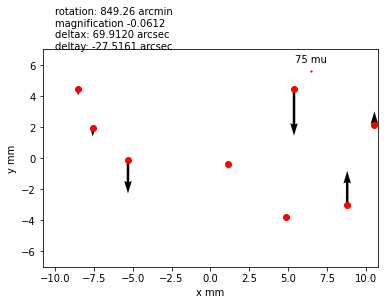

In [188]:
mask_plate_scale = 42.26134
plt.figure()
plt.axis('equal')
plt.plot(slit_pos[:,0], slit_pos[:,1], 'or')
qv = plt.quiver(slit_pos[:,0], slit_pos[:,1], 0., delta[:,0]*mask_plate_scale)
plt.quiverkey(qv, .8,.9,.075, "75 mu", color='r')
plt.xlim([-13, 13])
plt.ylim([-7,7])
plt.xlabel('x mm')
plt.ylabel('y mm')
plt.text(-10,7,"rotation: {:.2f} arcmin\nmagnification {:.4f}\ndeltax: {:.4f} arcsec\ndeltay: {:.4f} arcsec".format(theta, gama, -deltay*3600, deltax*3600))
plt.show()


In [189]:
sit_pos14_obs_det = np.array([1312.8, 1357.7])
slit_pos14_obs = inv_map(slit_coord_obs_wave, sit_pos14_obs_det[0], sit_pos14_obs_det[1]).T
print(slit_pos14_obs, slit_pos[2])

print(G2UV.FieldP.pix2local(slit_pos[2]))
print(G2UV.FieldP.pix2local(slit_pos14_obs))

[-5.02836519  3.57815955] [10.563193  2.136243]
<SkyCoord (SkyOffsetICRS: rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (36.9049, 0.65245)>): (lon, lat) in deg
    (0.05063688, -0.25038687)>
<SkyCoord (SkyOffsetICRS: rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (36.9049, 0.65245)>): (lon, lat) in deg
    (0.08471611, 0.11905102)>


In [190]:
G2UVcor  = Guider2UV(guider_wcs=G2UVnew.GuiderP.w, 
                     Field_center=G2UVnew.FieldP.center, 
                     Field_rotation=G2UVnew.FieldP.rotation,
                     Field_gamma=gama,
                     mask_rotation=G2UVnew.mask_rotation + theta*u.arcmin)


#deltaFOV = - 1/gama*deltax

#G2UVnew  = Guider2UV(guider_wcs=G2UV.GuiderP.w, 
#                     Field_center=G2UV.FieldP.center, 
#                     Field_rotation=G2UV.FieldP.rotation,
#                     Field_gamma=gama)
#                     #mask_rotation=theta*u.arcmin)
#
#deltaFOV = - deltax

newFOVcenter = coordinates.SkyCoord(G2UVnew.FOV_center_guider_coord.lon + deltax*u.deg, 
                              G2UVnew.FOV_center_guider_coord.lat + deltay*u.deg,
                              frame = G2UVnew.GuiderP.localframe)
                     
G2UVcor.FOV_center_guider_coord = newFOVcenter

#G2UVnew.FOV_guider_coord = G2UV.FOV_guider_coord


## check new model on new slit #??

start from last slit #46

In [194]:
slitcheck = '21'
slit_pos5 =   np.array([F4[F4['Internal-count']==slitcheck]['x_mm'][0], F4[F4['Internal-count']==slitcheck]['y_mm'][0]])

print("slit position in mm on mask:", slit_pos5)
slit_coord5 = G2UVcor.SienceMask2guider(slit_pos5, angle=True)
print("slit coord in guider local frame:", slit_coord5.to_string(u'dms'))
slit_coord5_pix = G2UVcor.SienceMask2guider(slit_pos5, angle=False)
print("slit coord in guider pixel frame:", slit_coord5_pix)

#frame move
theta_EL =  (slit_coord5.lon.deg -  slit_coord[0].lon.deg)/2./Elg
theta_CE = -(slit_coord5.lat.deg -  slit_coord[0].lat.deg)/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

slit position in mm on mask: [-0.226751  5.705359]
slit coord in guider local frame: ['0d09m46.12297342s -0d00m53.5688165s']
slit coord in guider pixel frame: [array([1287.87410866]), array([473.31418859])]
EL: [131.54413084] arcsec 
CE: [-164.18365868] arcsec


## check new model on known slit #??

start from last slit #14

In [196]:
slitcheck2 = slits[2]
slit_pos6 =   np.array([F4[F4['Internal-count']==slitcheck2]['x_mm'][0], F4[F4['Internal-count']==slitcheck2]['y_mm'][0]])

print("slit position in mm on mask:", slit_pos6)
slit_coord6 = G2UVcor.SienceMask2guider(slit_pos6, angle=True)
print("slit coord in guider local frame:", slit_coord6.to_string(u'dms'))
slit_coord6_pix = G2UVcor.SienceMask2guider(slit_pos6, angle=False)
print("slit coord in guider pixel frame:", slit_coord6_pix)

#frame move
theta_EL =  (slit_coord6.lon.deg -  slit_coord5.lon.deg)/2./Elg
theta_CE = -(slit_coord6.lat.deg -  slit_coord5.lat.deg)/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

slit position in mm on mask: [10.563193  2.136243]
slit coord in guider local frame: ['0d09m50.27410018s 0d00m07.52402965s']
slit coord in guider pixel frame: [array([1292.30202511]), array([541.32931779])]
EL: [2.06772669] arcsec 
CE: [-29.67746685] arcsec


compared observed vs diffuse

| wavelength | diffuse   | observed |
|------------|-----------|----------|
| 0.21382    |           |           
| 0.20619    | 1738.3-1531.2| 1754.3x1574.3
| 0.20255    |   |


In [197]:
# compute observed position on mask
slit_coord5_obs_det = np.array([1754.3, 1574.3])
slit_coord5_obs_wave = 0.20619
slit_pos5_obs = mask_det_map.inv_map(slit_coord5_obs_wave, slit_coord5_obs_det[0], slit_coord5_obs_det[1])
print("observed slit position in mm on mask:", slit_pos5_obs)
slit_coord5_obs = G2UVnew.SienceMask2guider(slit_pos5_obs, angle=True)
print("observed slit coord in guider local frame:", slit_coord5_obs.to_string(u'dms'))
slit_coord5_obs_pix = G2UVnew.SienceMask2guider(slit_pos5_obs, angle=False)
print("observed slit coord in guider pixel frame:", slit_coord5_obs_pix)


observed slit position in mm on mask: [-8.0507355  -3.21109152]
observed slit coord in guider local frame: ['0d06m02.79221588s 0d11m49.15474044s']
observed slit coord in guider pixel frame: [array([1062.67180859]), array([1318.89091796])]


## F4 Star sequence

s18 - s29 - s34 - s14 


In [200]:
star_target_path = "/Users/Vincent/Github/FireBallPipe/Calibration/Targets/2022/GuidingStars/"
F4_stars = Table.read(star_target_path + "F4_guidingstars.fits", format='fits')
F4_stars_coords = coordinates.SkyCoord(F4_stars['RA']*u.deg, F4_stars['DEC']*u.deg)


### star s18, from guider center

In [201]:
star_pos1_radec = F4_stars_coords[F4_stars['Internal count']==18]
print("star position Ra/Dec: ", star_pos1_radec)
star_coord1 = G2UVnew.SienceMask2guider(star_pos1_radec, world=True, angle=True)
print("Star position in guider local frame: ", star_coord1)
star_coord1_pix = G2UVnew.SienceMask2guider(star_pos1_radec, world=True, angle=False)
print("Star position in guider pixel frame: ", star_coord1_pix)

#frame move
theta_EL =  star_coord1.lon.deg/2./Elg
theta_CE = -star_coord1.lat.deg/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(36.877561, 0.53311)]>
Star position in guider local frame:  <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39242605, 36.41307253)>): (lon, lat) in deg
    [(0.05903728, 0.03320441)]>
Star position in guider pixel frame:  [array([879.11653979]), array([673.54577459])]
EL: [105.86586903] arcsec 
CE: [-58.06772305] arcsec


observed star position on guider: 896.2 671.0 retour: 895.3x671.5

### star s29

In [202]:
star_pos2_radec = F4_stars_coords[F4_stars['Internal count']==29]
print("star position Ra/Dec: ", star_pos2_radec)
star_coord2 = G2UVnew.SienceMask2guider(star_pos2_radec, world=True, angle=True)
print("Star position in guider local frame: ", star_coord2)
star_coord2_pix = G2UVnew.SienceMask2guider(star_pos2_radec, world=True, angle=False)
print("Star position in guider pixel frame: ", star_coord2_pix)

#frame move
#theta_EL =  star_coord2.lon.deg/2./Elg
#theta_CE = -star_coord2.lat.deg/2./CEg
#print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

theta_EL =  (star_coord2.lon.deg - star_coord1.lon.deg)/2./Elg
theta_CE = -(star_coord2.lat.deg - star_coord1.lat.deg)/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(36.987137, 0.402799)]>
Star position in guider local frame:  <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39242605, 36.41307253)>): (lon, lat) in deg
    [(-0.07024471, -0.07759171)]>
Star position in guider pixel frame:  [array([353.76231425]), array([215.25627296])]
EL: [-231.8289431] arcsec 
CE: [193.75974755] arcsec


observed star position on guider: aller 373.2 x 227.2 - retour 372.5x217.6

### star s34

In [203]:
star_pos3_radec = F4_stars_coords[F4_stars['Internal count']==34]
print("star position Ra/Dec: ", star_pos3_radec)
star_coord3 = G2UVnew.SienceMask2guider(star_pos3_radec, world=True, angle=True)
print("Star position in guider local frame: ", star_coord3)
star_coord3_pix = G2UVnew.SienceMask2guider(star_pos3_radec, world=True, angle=False)
print("Star position in guider pixel frame: ", star_coord3_pix)

#frame move
#theta_EL =  star_coord2.lon.deg/2./Elg
#theta_CE = -star_coord2.lat.deg/2./CEg
#print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

theta_EL =  (star_coord3.lon.deg - star_coord2.lon.deg)/2./Elg
theta_CE = -(star_coord3.lat.deg - star_coord2.lat.deg)/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(37.023638, 0.390844)]>
Star position in guider local frame:  <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39242605, 36.41307253)>): (lon, lat) in deg
    [(-0.08185662, -0.11420421)]>
Star position in guider pixel frame:  [array([309.20173299]), array([59.75261016])]
EL: [-20.8225283] arcsec 
CE: [64.02776367] arcsec


### star s34

In [204]:
star_pos4_radec = F4_stars_coords[F4_stars['Internal count']==14]
print("star position Ra/Dec: ", star_pos4_radec)
star_coord4 = G2UVnew.SienceMask2guider(star_pos4_radec, world=True, angle=True)
print("Star position in guider local frame: ", star_coord4)
star_coord4_pix = G2UVnew.SienceMask2guider(star_pos4_radec, world=True, angle=False)
print("Star position in guider pixel frame: ", star_coord4_pix)

#frame move
#theta_EL =  star_coord2.lon.deg/2./Elg
#theta_CE = -star_coord2.lat.deg/2./CEg
#print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

theta_EL =  (star_coord4.lon.deg - star_coord3.lon.deg)/2./Elg
theta_CE = -(star_coord4.lat.deg - star_coord3.lat.deg)/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(36.867454, 0.492628)]>
Star position in guider local frame:  <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39242605, 36.41307253)>): (lon, lat) in deg
    [(0.01846044, 0.04293117)]>
Star position in guider pixel frame:  [array([715.97692811]), array([714.60307498])]
EL: [179.8889344] arcsec 
CE: [-274.79762006] arcsec


star pos aller: 732.2 710.0 retour: 732.0 718.5

In [205]:
#frame move
theta_EL =  (0. - star_coord4.lon.deg)/2./Elg
theta_CE = -(0. - star_coord4.lat.deg)/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

EL: [-33.10333202] arcsec 
CE: [75.07783189] arcsec
